
--- Genre Influence on Production Budget Analysis ---
CONCLUSION: Genre significantly influences production budget (p=0.0000)


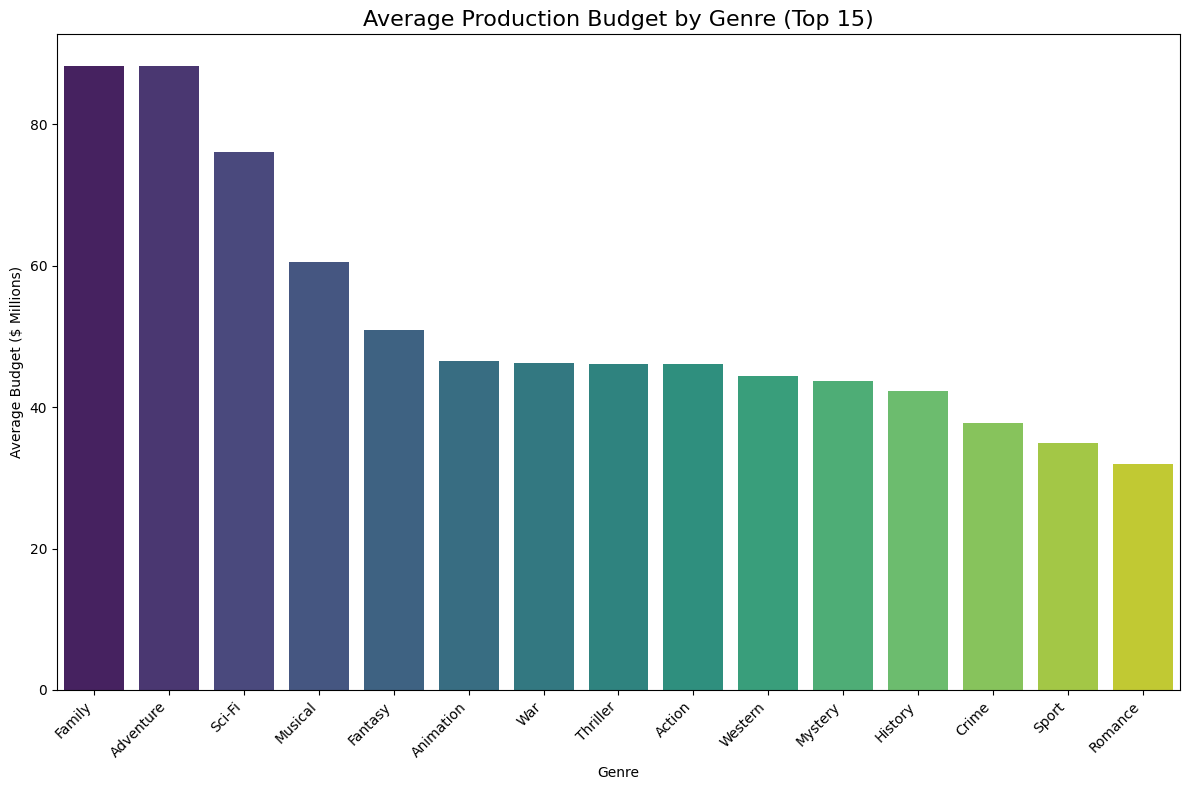


--- Budget-Profitability Correlation Analysis ---
CONCLUSION: Budget-to-box office correlation varies significantly by genre

Top 10 Strongest Budget-to-Box Office Correlations:
                 correlation        p_value
primary_genre                              
War                 0.885498   1.669185e-11
Sci-Fi              0.822665   1.450680e-06
Musical             0.807054   3.428376e-14
Thriller            0.794713  1.426328e-111
Mystery             0.783875   1.346432e-26
Action              0.775325   1.101359e-22
Adventure           0.749189   2.227764e-87
Romantic Comedy     0.700734   5.789326e-04
Family              0.674764   1.147915e-19
Comedy              0.668263   2.619636e-52


/var/folders/7h/003pn2vs5_x723vmnbb7vp8c0000gn/T/ipykernel_30565/1795619013.py:123: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10')


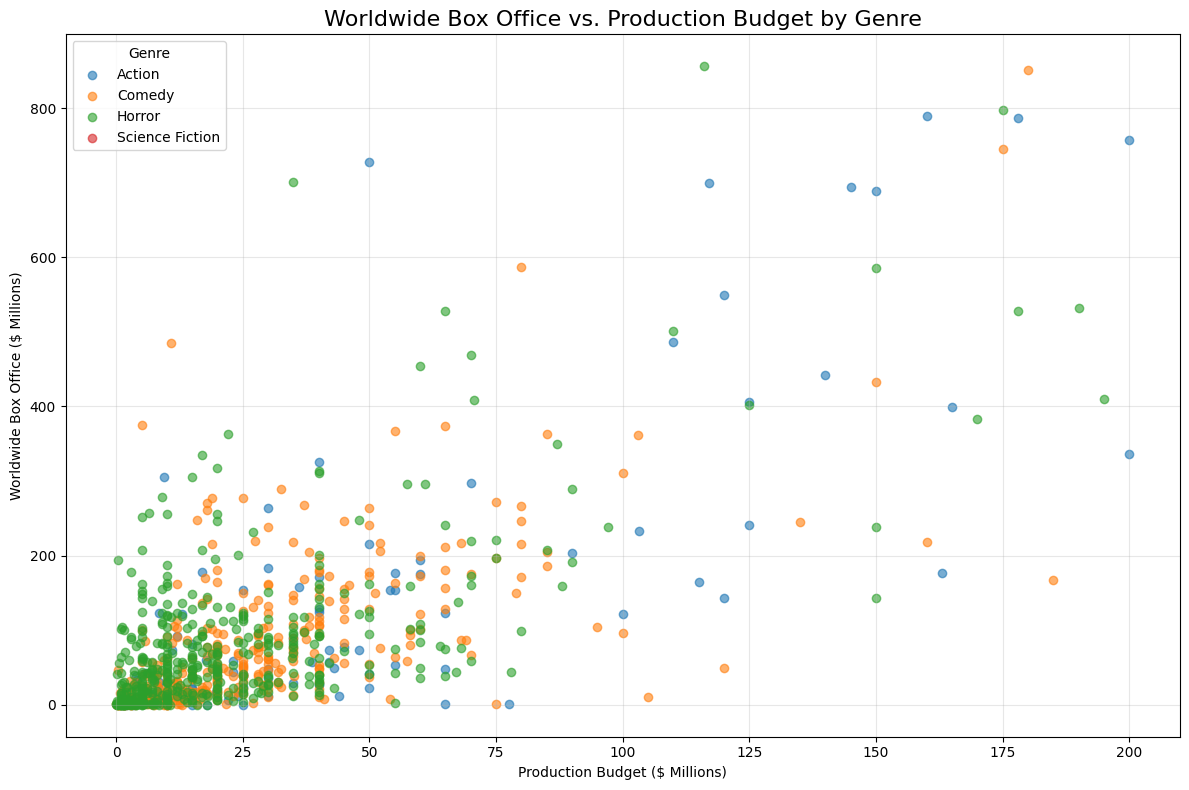


# 1. Does a film's genre significantly influence its production budget?
Yes, genre significantly influences budget allocation decisions, with the Family and Adventure genres requiring the highest average investments due to inherent production costs like special effects, while genres like Romance typically require much lower funding. This substantial variation confirms that genre is a fundamental determinant of a movie's financial requirement before filming even begins.

# 2. How does the budget-profitability correlation vary by genre?
The relationship between budget and profitability varies widely by genre: while higher budgets in Action and Sci-Fi films show a strong positive correlation with box office returns, confirming high investment as a valid strategy, genres like Horror can yield extremely high profits even from minimal budgets. Therefore, investment strategy must be genre-specific, recognizing that increased funding reliably drives success for some categories but is less cri

In [ ]:
# Author: Juliusz Dokrzewski
# =============================================================================


# =============================================================================
# GENRE INFLUENCE ON MOVIE BUDGET AND PROFITABILITY ANALYSIS
# =============================================================================
# RESEARCH QUESTIONS: 
# 1. Does a film's genre significantly influence its production budget?
# 2. How does the budget-profitability correlation vary by genre?
# =============================================================================

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from sqlalchemy import create_engine
from scipy import stats

# =============================================================================
# STEP 1: DATA LOADING AND GENRE PROCESSING
# =============================================================================

# The connection string establishes the communication channel between Python and the database.
engine = create_engine('postgresql://admin@localhost:5432/moviedb')

# Query to retrieve movie data, filtering for complete financial records and valid genres.
query = """
SELECT m.title, m.genre_ids, bp.production_budget, bp.worldwide_box_office
FROM movie m
JOIN box_office_performance bp ON m.movie_id = bp.movie_id
WHERE bp.production_budget > 0 AND bp.worldwide_box_office > 0
AND m.genre_ids IS NOT NULL AND m.genre_ids != ''
"""
data = pd.read_sql_query(query, engine)

# Load genre lookup table for ID-to-Name translation.
genre_query = "SELECT \"GenreId\", \"Name\" FROM genre ORDER BY \"GenreId\""
genres_df = pd.read_sql_query(genre_query, engine)
# Create a mapping dictionary from GenreId to Name.
genre_lookup = dict(zip(genres_df['GenreId'], genres_df['Name']))

# Define primary genre as the first genre ID listed (for single-genre classification).
def get_primary_genre(genre_ids_string):
    try:
        first_id = int(genre_ids_string.split(',')[0].strip())
        return genre_lookup.get(first_id, 'Unknown')
    except (ValueError, IndexError):
        return 'Unknown'

data['primary_genre'] = data['genre_ids'].apply(get_primary_genre)

# =============================================================================
# STEP 2: GENRE INFLUENCE ON BUDGET ANALYSIS
# =============================================================================

# Calculate average budget statistics by genre and filter for statistical reliability.
genre_budget_stats = data.groupby('primary_genre').agg(
    movie_count=('production_budget', 'count'),
    mean_budget=('production_budget', 'mean')
)
major_genres = genre_budget_stats[genre_budget_stats['movie_count'] >= 20].index.tolist()

# **ANOVA test** compares average production budgets across all major genres simultaneously.
genre_budget_groups = [
    data[data['primary_genre'] == genre]['production_budget'].values
    for genre in major_genres
]

if len(genre_budget_groups) >= 2:
    f_statistic, p_value = stats.f_oneway(*genre_budget_groups)
    print(f"\n--- Genre Influence on Production Budget Analysis ---")
    if p_value < 0.05:
        print(f"CONCLUSION: Genre significantly influences production budget (p={p_value:.4f})")
    else:
        print(f"CONCLUSION: No significant evidence that genre influences budget (p={p_value:.4f})")

# Visualize top 15 genres by average budget.
top_15_budget_genres = genre_budget_stats.sort_values('mean_budget', ascending=False).head(15)

plt.figure(figsize=(12, 8))
sns.barplot(
    x=top_15_budget_genres.index,
    y=top_15_budget_genres['mean_budget'] / 1_000_000,
    hue=top_15_budget_genres.index, 
    palette='viridis',
    legend=False 
)
plt.title('Average Production Budget by Genre (Top 15)', fontsize=16)
plt.xlabel('Genre')
plt.ylabel('Average Budget ($ Millions)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# =============================================================================
# STEP 3: BUDGET-PROFITABILITY CORRELATION ANALYSIS
# =============================================================================

# Calculate profit and ROI for profitability analysis.
data['profit'] = data['worldwide_box_office'] - data['production_budget']
data['roi_percentage'] = (data['profit'] / data['production_budget']) * 100

# The **Pearson correlation coefficient** (often denoted as $r$) is a measure of the linear relationship 
# between two sets of data. It quantifies the strength and direction of the association.
#
# **How it's used:**
# It calculates the covariance of the two variables (e.g., 'production_budget' and 'worldwide_box_office')
# divided by the product of their standard deviations. The resulting value ranges from -1 to +1.
# - A value of **+1** indicates a perfect positive linear relationship (as one increases, the other increases proportionally).
# - A value of **-1** indicates a perfect negative linear relationship (as one increases, the other decreases proportionally).
# - A value of **0** indicates no linear relationship.
#
# **Why it's used here:**
# It's used to determine if a **higher budget tends to result in a higher box office** (positive correlation) 
# or if there's no strong linear link between the two within a specific film **genre**.
# The associated **$p$-value** from `stats.pearsonr` helps determine if the observed correlation is statistically significant, 
# meaning it's unlikely to have occurred by random chance.


# **Pearson Correlation** measures the relationship between budget and box office by genre.
def calculate_genre_correlation(genre_data):
    if len(genre_data) >= 10:  # Minimum sample size for reliable correlation
        correlation, p_value = stats.pearsonr(
            genre_data['production_budget'], 
            genre_data['worldwide_box_office']
        )
        return pd.Series([correlation, p_value], index=['correlation', 'p_value'])
    return pd.Series([None, None], index=['correlation', 'p_value'])

# Apply correlation analysis across all genres.
genre_correlations = data.groupby('primary_genre').apply(
    calculate_genre_correlation,
    include_groups=False
).dropna().sort_values('correlation', ascending=False)

print(f"\n--- Budget-Profitability Correlation Analysis ---")
print(f"CONCLUSION: Budget-to-box office correlation varies significantly by genre")
print(f"\nTop 10 Strongest Budget-to-Box Office Correlations:")
print(genre_correlations.head(10))

# Visualize budget vs box office relationship for key genres.
plt.figure(figsize=(12, 8))
selected_genres = ['Action', 'Comedy', 'Horror', 'Science Fiction']
colors = cm.get_cmap('tab10')

for i, genre in enumerate(selected_genres):
    genre_data = data[data['primary_genre'] == genre]
    plt.scatter(
        genre_data['production_budget'] / 1_000_000, 
        genre_data['worldwide_box_office'] / 1_000_000, 
        label=genre, alpha=0.6, color=colors(i)
    )

plt.title('Worldwide Box Office vs. Production Budget by Genre', fontsize=16)
plt.xlabel('Production Budget ($ Millions)')
plt.ylabel('Worldwide Box Office ($ Millions)')
plt.legend(title='Genre')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# =============================================================================
# STEP 4: BUSINESS INSIGHTS
# =============================================================================

print("""
# 1. Does a film's genre significantly influence its production budget?
Yes, genre significantly influences budget allocation decisions, with the Family and Adventure genres requiring the highest average investments due to inherent production costs like special effects, while genres like Romance typically require much lower funding. This substantial variation confirms that genre is a fundamental determinant of a movie's financial requirement before filming even begins.

# 2. How does the budget-profitability correlation vary by genre?
The relationship between budget and profitability varies widely by genre: while higher budgets in Action and Sci-Fi films show a strong positive correlation with box office returns, confirming high investment as a valid strategy, genres like Horror can yield extremely high profits even from minimal budgets. Therefore, investment strategy must be genre-specific, recognizing that increased funding reliably drives success for some categories but is less critical for the profitability of others.
""")